# IMPORTS 

In [2]:
import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

import plotly.graph_objects as go
import yfinance as yf
import statistics as st

# Part 1. Is the Monday Effect Real?
## What is The Monday Effect?
According to Investopedia.com, **The Monday Effect** is "a financial theory that suggests that stock market returns will follow the prevailing trends from the previous Friday when it opens the following Monday." Then for a Security A, if A was trending down on Friday January 1st, the intraday percentage change $$\mathrm{pct\_change}(A, \mathrm{''Friday, January, 01''}) < 0,$$ then the Monday Effect implies that the $$\mathrm{pct\_change}(A, \mathrm{''Monday, January, 04''}) < 0$$
and vise versa if the Friday experienced a positive percentage change.

## The History of The Monday Effect
So I certainly am not the first person to ever look at this effect. **The Monday Effect** is a financial markets anomaly that was originally discovered and researched by Frank Cross in 1973 (Seen here: ["Frank Cross' Research on The Monday Effect"](https://dailyspeculations.com/scholarly/faj.v29.n6.67.pdf )). 
Here's the TLDR:
* Cross looked at the Standard & Poor's 500 Composite Index from 1953 to 1970. 1953 is significant because it was the first year the market closed on Saturdays.
* The probability that the SP500 Composite Index trended positive on a Monday given it also trended up on the preceding Friday is ~$48.8\%$
* The average percent change of the SP500 Composite on Monday's after a positive trending Friday was $0\%$
* The median percent change of the SP500 Copmositve on Monday's after a positive trending Friday was $0\%$
* The probability that the SP500 Composite Index trended positive on a Monday given it also trended down on the preceding Friday is ~$24.0\%$
* The average percent change of the SP500 Composite on Monday's after a negative trending Friday was $-0.48\%$
* The median percent change of the SP500 Copmositve on Monday's after a negative trending Friday was $-0.40\%$

## What Factors Impact The Monday Effect?
To begin, **The Monday Effect**, is not a perfect estimator of where the market will be headed on a Monday. There are so many factors welded deep into the market that dictate where the market goes. These factors include, earnings, breaking news, supply and demand, even global economic and social conditions (just as seen with the COVID-19 pandemic in 2020 and the subsequent high volatility markets since then).

However, part of this research will try to find out if we can dig a little deeper and find out if there are predictors built into the market. Frank Cross used the SP500 Composite Index to perform his research. I aim to replicate this trial first with the SPDR S&P 500 ETF Trust, an exchange-traded fund which tracks the S&P 500 stock market index, but using a more recent scope of time. The second goal of this project will be to breakdown the S&P 500 into the securities that form it and to use a Bayesian Classifier Algorithm to see if we can use the trends of each individual seucrity to predict how the overall index will move.

In [3]:
# Get historical data
spy_df = yf.Ticker("SPY").history(start = "2012-01-01", end = "2022-06-01", period = "1d", interval = "1d")
# Reset index so we can do some manipulation
spy_df = spy_df.reset_index(0)
# We are analyzing by day so we need to add a day of the week to each 
spy_df['Dayofweek'] = pd.to_datetime(spy_df['Date']).dt.dayofweek
# Drop the rcolumns that are excess data
spy_df = spy_df.drop(columns=['High','Low','Dividends', 'Stock Splits'])
# Add a daily percentage change column 
spy_df['Pct_Change'] = (spy_df['Close'] / spy_df['Open'] - 1)*100
# Add a boolean that represents the percentage change (will be useful to make comparisons later on)
spy_df['Change'] = spy_df['Pct_Change'] > 0
# Rearrange some of these new columns now
spy_df = spy_df.reindex(columns = ['Date', 'Dayofweek', 'Open', 'Close', 'Volume', 'Pct_Change', 'Change'])

## How do we define pairings between Fridays and Mondays historically?
So, the Monday Effect technically is only defined in general as a pattern between Fridays and the following Monday. However, because of bank holidays, a Friday does not necessarily need to be the last day of a week and a Monday does not necessarily need to be the first day of the week, in this context Therefore, I had to come up with a different way to keep track of "Friday"-"Monday" pairings.

In [4]:
# To make it easier to keep track of the days, I also add the week and the year
spy_df['Week'] = spy_df['Date'].dt.isocalendar().week
spy_df['Year'] = spy_df['Date'].dt.isocalendar().year

In [5]:
# Lets take a look at our dataframe after some of that processing
spy_df.head()

,Date,Dayofweek,Open,Close,Volume,Pct_Change,Change,Week,Year
0,2012-01-03,1,104.284119,104.071892,193697900,-0.203508,False,1,2012
1,2012-01-04,2,103.827020,104.235146,127186500,0.393082,True,1,2012
2,2012-01-05,3,103.671949,104.512680,173895000,0.810953,True,1,2012
3,2012-01-06,4,104.643262,104.243301,148050000,-0.382214,False,1,2012
4,2012-01-09,0,104.480017,104.496346,99530200,0.015628,True,2,2012


In [6]:
# identify the "friday" "monday" pairings
pairs = []
for index, item in spy_df.iterrows():
    # given current day, check if the next day belongs to the next week, if so then we can keep current day and the next day
    if index+1 < len(spy_df) and item.Week != spy_df.iloc[index+1].Week:
        pairs.append((spy_df.iloc[index], spy_df.iloc[index+1]))

In [7]:
pos_pos = []
pos_neg = []
neg_pos = []
neg_neg = []
for pair in pairs:
    day1 = pair[0]
    day2 = pair[1]
    if day1.Change and day2.Change:
        pos_pos.append(day2.Pct_Change)
    elif day1.Change and not day2.Change:
        pos_neg.append(day2.Pct_Change)
    elif not day1.Change and day2.Change:
        neg_pos.append(day2.Pct_Change)
    else:
        neg_neg.append(day2.Pct_Change)

total_pos = (pos_pos + pos_neg)
total_neg = (neg_pos + neg_neg)
avg_pos_pos = st.mean(pos_pos)
avg_pos_neg = st.mean(pos_neg)
avg_neg_pos = st.mean(neg_pos)
avg_neg_neg = st.mean(neg_neg)

print(f'{round(len(pos_pos) * 100/len(total_pos), 2)}% of the {len(total_pos)} positive "Fridays" were followed by a positive "Monday" with an average increase of {round(avg_pos_pos, 4)}%')
print(f'{round(len(pos_neg) * 100/len(total_pos), 2)}% of the {len(total_pos)} positive "Fridays" were followed by a negative "Monday" with an average decrease of {round(avg_pos_neg, 4)}%')
print(f'This yields an average change after a positive "Friday" of {round(st.mean(total_pos), 4)} with standard deviation {round(st.stdev(total_pos), 4)}')
print(f'{round(len(neg_pos) * 100/len(total_neg), 2)}% of the {len(total_neg)} negative "Fridays" were followed by a positive "Monday" with an average increase of {round(avg_neg_pos,4)}%')
print(f'{round(len(neg_neg) * 100/len(total_pos), 2)}% of the {len(total_neg)} negative "Fridays" were followed by a negative "Monday" with an average decrease of {round(avg_neg_neg, 4)}%')
print(f'This yields an average change after a negative "Friday" of {round(st.mean(total_neg), 4)} with standard deviation {round(st.stdev(total_neg), 4)}')


55.33% of the 300 positive "Fridays" were followed by a positive "Monday" with an average increase of 0.3842%
44.67% of the 300 positive "Fridays" were followed by a negative "Monday" with an average decrease of -0.454%
This yields an average change after a positive "Friday" of 0.0098 with standard deviation 0.6512
55.97% of the 243 negative "Fridays" were followed by a positive "Monday" with an average increase of 0.5064%
35.67% of the 243 negative "Fridays" were followed by a negative "Monday" with an average decrease of -0.5816%
This yields an average change after a negative "Friday" of 0.0273 with standard deviation 0.7629


At face value it looks like **The Monday Effect** does not quite hold much value. When we look at the predictability conditioning on the return of the "Friday" before it is just about 55-56% in both cases. Let's test this out with a more theoretical approach via a **Two Sample T-test**. 

## Two Sample T-Test: Comparing Returns of Positive "Fridays" to Negative "Fridays"
The two-sample t-test (also known as the independent samples t-test) is a method used to test whether the unknown population means of two groups are equal or not. We can use this test when our two samples follow an approximately normal distribution. In this case, while we do not know the exact distribution of the returns, we can apply the **Central Limit Theorem (CLT)** to claim that both the Positive Fridays and the Negative Fridays samples follow an approximately normal distribution. Just to see if the assumption fails, lets plot the density of each sample population.

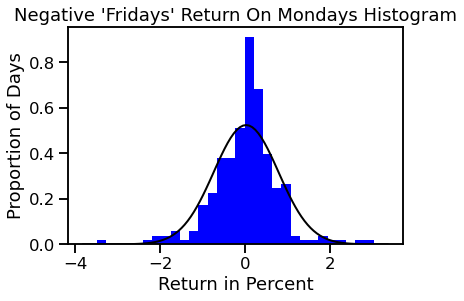

In [8]:
from scipy.stats import norm
  


plt.hist(neg_pos+neg_neg, bins=30, density=True, color='b')

plt.title("Negative 'Fridays' Return On Mondays Histogram")
plt.xlabel("Return in Percent")
plt.ylabel("Proportion of Days")

# Fitting a normal distribution to compare against
mu, std = norm.fit(neg_pos+neg_neg) 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)

  
plt.show()

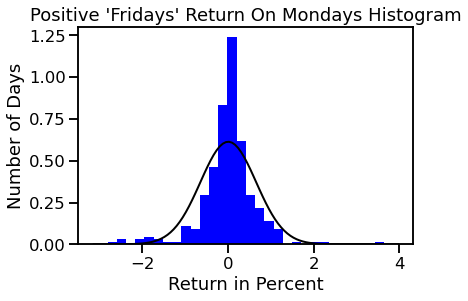

In [9]:
plt.hist(pos_pos+pos_neg, bins=30, density=True, color='b')
plt.title("Positive 'Fridays' Return On Mondays Histogram")
plt.xlabel("Return in Percent")
plt.ylabel("Number of Days")

# Fitting a normal distribution to compare against
mu, std = norm.fit(pos_neg+pos_pos) 
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)

plt.show()

From the histograms and the normal distributions fitted to each dataset, we can see that the data does fit an approximately normal distribution (the main differnece being the higher peak around 0). With that shown, lets conduct our Two Sample T-test based on the scipy library function. For this Two Sample T-test we will also need to define hypothesis and the population means we are comparing:

We will first define
    $$\mu_1\space=\space\mathrm{The\space Average\space Return\space After\space a\space Positive\space "Friday"}\quad\mathrm{and}\newline
    \mu_2\space=\space\mathrm{The\space Average\space Return\space After\space a\space Negative\space "Friday"}$$
    and a standard $\alpha\space=\space0.05.\newline$
Then we can define our hypothesis:
    $$H_O:\space \mu_1\space=\space\mu_2$$
    $$H_{Alt}:\space \mu_1\space!=\space\mu_2$$

In [10]:
import scipy.stats as stats
stats.ttest_ind(a=pos_neg+pos_pos, b=neg_pos+neg_neg, equal_var=False)

Ttest_indResult(statistic=-0.28444805696901715, pvalue=0.7761903859017418)

## T-Test Results
Since the p-value returned for this T-test is 0.776 and $0.776 > 0.05 = \alpha$ we cannot reject our null hypothesis $H_O$ in favor of the alternative hypothesis $H_{Alt}$. This means that we can conclude with power 0.95 that the two populations have the same mean and that The Monday Effect is not a valid indicator of market performance, at least for the SP500.

Where does that leave us now?

Well, the next goal is to figure out some way of estimating whether an equity or ETF will have a positive daily percentage change or not. I hypothesize that we can use equities with high betas, beta(equity) > 1, to predict market movement.

# Part 2. Using High Beta S&P 500 Equities to Predict S&P 500 Movement

## What is Beta?
Beta($\beta$) is a measure of volatility of a security compared to the market as a whole, typically using the S&P 500 as a basis. Also note that $$\beta = \frac{\mathrm{Systematic\space Risk + Unsystematic\space Risk}}{Systematic\space Risk}$$ where **Systematic Risk** is the risk inherent to the entire market or market segmnet, in this case the SP500 and **Unsystematic Risk** is the risk uncertainty associated with an individual stock or industry. Here's a few examples.

$\beta = 1$
Indicates the equity is strongly correlated with the S&P 500 and does add any unsysteamtic risk.

$\beta < 1$
Indicates the equity is less risky than the S&P 500 and typically moves more slowly than the market.

$\beta > 1$
Indicates the equity is more volatile than the S&P 500, adding unsystematic risk.

$\beta < 0$
Indicates an inverse correlation relationship witht he S&P 500, i.e. moves opposite of the S&P 500. Without loss of generality, mirror the above scenario to see what negative $\beta$ values mean.

For further reading, go to https://www.investopedia.com/terms/b/beta.asp.

The next thing we need to do is identify the beta for all the equities in the S&P 500 on a specific time horizon and select the equities with the highest beta. 

It is important to note that beta is not a constant quantity, in fact, it changes over time and as the price of the security fluctuates. Calculating beta is then directly related to our time horizon. For this analysis, I will be using Q1 and Q2 of 2022 as the time period of data to use. It then follows that all further analysis will be done on this same time frame. 

## Calculating Beta

### Benchmark Selection

Calculating beta can be done in a variety of ways, but in essence, we are trying to find the slope of linear regression that best fits the data when we plot return of a benchmark vs return of security in quesiton. What is a benchmark? The benchmark here is whatever baseline metric we are using to compare our security against. Typically, this benchmark is an ETF of an exchange such as $SPY (etf for S&P 500), $ONEQ (etf for Nasdaq), or $IWM (etf for Russell 2000). For our analysis we will be using $SPY as it models the S&P 500, which is the market context we are aiming to focus on.

### Beta Formulas [(source)](https://www.wallstreetmojo.com/beta-formula/) [(Additional Source)](https://www.investopedia.com/terms/b/beta.asp#:~:text=A%20security's%20beta%20is%20calculated,returns%20over%20a%20specified%20period.)


 So there are a few formulas to calculate beta, and as stated earlier, the goal is to find a relationship between the returns of a benchmark and the security question. The first method is pretty naïve and it is establishing a relationship between the covariance of the security and the benchmark divided by the variance of the benchmark and you'll notice that this formula looks pretty familiar because it is very similar to an R squared calculation. 
 
 Given a security $ABC and the benchmark $SPY, this yields:
 $$\beta = \frac{Cov(\mathrm{R_{ABC}}, \mathrm{R_{SPY}})}{Var(\mathrm{R_{SPY}})}$$
where $R_{xyz}$ is the daily returns for security xyz. So, the next step is calculating the Beta for every equity in the SP500.

### Calculating SP500 Betas

#### Data Gathering

In [40]:
# Uncomment to download data again or to update the timeframe

# https://stackoverflow.com/questions/58890570/python-yahoo-finance-download-all-sp-500-stocks
#
# import bs4 as bs
# import requests
# import yfinance as yf
# import datetime

# resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# soup = bs.BeautifulSoup(resp.text, 'lxml')
# table = soup.find('table', {'class': 'wikitable sortable'})
# tickers = []
# for row in table.findAll('tr')[1:]:
#     ticker = row.findAll('td')[0].text
#     tickers.append(ticker)

# tickers = [s.replace('\n', '') for s in tickers]
# tickers.append("SPY")
# start = datetime.datetime(2022,1,1)
# end = datetime.datetime(2022,5,30)
# data = yf.download(tickers, start=start, end=end, auto_adjust=True, rounding=True)

# Eliminate columnns with missing data (typically delisted tickers like BF.B and BRK.B)
# data = data.dropna(axis=1)
# df = data.Close
# df.to_csv("SP500Historical.csv")

In [42]:
df = pd.read_csv("SP500Historical.csv")
df.head()

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2022-01-03,155.69,18.75,230.97,180.96,130.34,130.98,366.29,136.75,44.55,...,87.77,66.55,61.12,56.31,115.39,133.96,124.57,583.90,62.52,232.33
1,2022-01-04,150.43,19.02,231.23,178.66,130.09,129.73,361.59,133.53,45.13,...,87.49,66.97,63.41,56.60,116.61,134.67,125.83,587.60,64.30,223.48
2,2022-01-05,147.85,18.68,230.64,173.91,130.77,130.86,338.20,132.93,44.60,...,84.25,67.63,64.20,55.69,115.02,132.96,125.42,558.18,64.45,214.98
3,2022-01-06,148.37,18.57,235.72,171.01,130.16,128.83,336.44,132.91,44.86,...,84.64,67.10,65.71,55.65,114.87,134.34,124.37,555.16,67.09,215.84
4,2022-01-07,144.42,19.28,232.24,171.18,129.82,131.47,319.28,133.32,45.07,...,84.55,67.69,66.25,55.82,113.95,132.80,123.62,530.86,68.21,209.55


#### Statistics Calculations

Recall the below definitions for random variables $X$ and $Y$,
$$Cov(X,X) = Var(X) = E[X*X] - E[X]E[X] = E[X^2] - (E[X])^2$$
$$Cov(X,Y) = E[X*Y] - E[X]E[Y]$$
$$E[X] = \mu_X$$
$$E[X] = \mu_Y$$

Recall the below theorems for independent random variables $X$ and $Y$,
$$E[X*Y] = E[X]E[Y]$$
$$Cov(X,Y) = E[X*Y] - E[X]E[Y] = 0$$


In [72]:
# calculate E[X]
Ex = dict()
# skip column 1 because it is the date column
for i in range(1,len(df.columns)):
    ticker = df.columns[i]
    Ex[ticker] = df[ticker].mean()

# Calculate E[XY]
Exy = dict()
for i in range(1,len(df.columns)):
    for j in range(i, len(df.columns)):
        t1 = df.columns[i]
        t2 = df.columns[j]
        xy = np.multiply(df[t1], df[t2])
        Exy[t1+"."+t2] = st.mean(xy)

SPY Variance: 441.4013096097845


In [75]:
# Now lets create our covariance dictionary, typically you would make this a matrix, but for easy of access I use a dictionary here
cov = dict()
for i in range(1,len(df.columns)):
    for j in range(i, len(df.columns)):
        t1 = df.columns[i]
        t2 = df.columns[j]
        cov[t1+"."+t2] = Exy[t1+"."+t2] - Ex[t1]*Ex[t2]

In [86]:
for i in range(1,5):
    for j in range(i, 5):
        t1 = df.columns[i]
        t2 = df.columns[j]
        print("Cov(" + t1 + ", " + t2 + ") " + str(cov[t1+"."+t2]))


Cov(A, A) 77.89382164552444
Cov(A, AAL) 1.1777643214145428
Cov(A, AAP) 77.15315207610183
Cov(A, AAPL) 66.43488266052009
Cov(AAL, AAL) 2.212582314494341
Cov(AAL, AAP) 8.754401384079301
Cov(AAL, AAPL) 5.877970030757751
Cov(AAP, AAP) 188.6271246827382
Cov(AAP, AAPL) 96.7503328142775
Cov(AAPL, AAPL) 104.8030968185376


In [77]:
# That seems like we just did a decent amount of work, surely there is a way to do this quicker? Yep!
# We can also use df.cov() to produce a covariance matrix
covmat = df.cov()
covmat.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,78.665048,1.189425,77.917045,67.092654,-45.842653,-59.674607,171.367940,53.055057,-0.161335,212.181869,...,65.107697,-17.408018,-48.218378,44.767894,72.253410,40.594644,5.547147,540.087610,38.503051,119.809238
AAL,1.189425,2.234489,8.841079,5.936168,0.100950,1.996777,12.959905,3.206054,0.830876,14.051259,...,3.085733,0.586123,-1.533799,-0.199011,3.638702,4.233531,3.603883,22.970905,0.860950,4.303390
AAP,77.917045,8.841079,190.494720,97.708257,-60.934618,-63.174841,199.577337,70.528061,2.452833,294.591782,...,82.974395,-15.889304,-69.840607,47.209559,105.966247,59.121197,13.527916,752.795279,41.476768,149.495804
AAPL,67.092654,5.936168,97.708257,105.840751,-14.595247,-30.235890,240.622672,49.196755,4.487057,233.981554,...,77.084681,-15.038448,-45.895373,46.583062,54.449324,42.803221,20.705767,523.915385,46.727291,125.128837
ABBV,-45.842653,0.100950,-60.934618,-14.595247,102.740424,94.807009,-22.258223,-37.358777,5.985257,-122.513728,...,-52.039475,21.559272,48.528559,-32.193714,-79.489259,-30.846212,20.879772,-431.992857,-18.351297,-69.986141


In [89]:
# And access specific entries with this format
covmat.loc['A']['A']

78.6650476024073

As you can see from both the covariance matrix output and the manual calculation, the outputs are extremely similar, with very slight deviation, probably due to rounding errors throughout the computation.

### Calculating the Betas

Recall $$\beta = \frac{Cov(\mathrm{R_{ABC}}, \mathrm{R_{SPY}})}{Var(\mathrm{R_{SPY}})}$$

In [90]:
# get the benchmark variance for the denominator
spy_var = st.variance(df['SPY'])
print("SPY Variance: " + str(spy_var))
print("SPY Variance from Covariance Matrix: " + str(covmat.loc['SPY']['SPY']))


SPY Variance: 441.4013096097845
SPY Variance from Covariance Matrix: 441.40130960978445


In [91]:
betas = dict()
for i in range(1,len(df.columns)):
    t1 = df.columns[i]
    betas[t1] = covmat.loc[t1]['SPY'] / covmat.loc['SPY']['SPY']

In [107]:
sorted_betas = {k: v for k, v in sorted(betas.items(), key=lambda item: item[1], reverse=True)}
sorted_betas

{'NVR': 15.896342380698089,
 'BKNG': 5.440301596284065,
 'NFLX': 4.670138051278543,
 'MTD': 4.2999858456557964,
 'CMG': 4.20484638104473,
 'ALGN': 3.821397012980983,
 'BLK': 3.4579066094976563,
 'SIVB': 3.0700310393601296,
 'IDXX': 2.8763507542154807,
 'EPAM': 2.825137706460215,
 'ZBRA': 2.761167841479117,
 'INTU': 2.757482132519098,
 'LRCX': 2.459958814183137,
 'NOW': 2.1522355978357566,
 'MSCI': 2.140287692188559,
 'BIO': 2.1303196719116917,
 'CHTR': 2.090810829315483,
 'ILMN': 2.0708878424391686,
 'TYL': 2.0389051874677824,
 'DPZ': 1.9383503971523033,
 'SBNY': 1.9307869018081307,
 'AZO': 1.790328856701428,
 'ADBE': 1.764282103318824,
 'TSLA': 1.7111792276631177,
 'WST': 1.6647506601165847,
 'CRL': 1.6030556848807,
 'NVDA': 1.5851349404296189,
 'META': 1.568932613282043,
 'ROK': 1.5482838277173694,
 'ANSS': 1.4956323647781682,
 'ISRG': 1.4565517903900893,
 'MKTX': 1.4345054657072887,
 'EQIX': 1.4183992307098927,
 'SPGI': 1.3849110195904457,
 'GNRC': 1.3301944116299178,
 'POOL': 1.314